# Tutorial: Boostrap and permutation tests

In this lab we will go over bootstrapping and permutation resampling methods. 

## Goals:
* Learn to use the `boot()` function
* Learn to write *for loops* to do permutation tests
* Construct a null distribution by permutation as a way of testing hypotheses 
* Quantify the sampling distribution of a statistic via bootstrapping (construct confidence intervals for your results)

This lab draws from the practice sets at the end of Chapter 5 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r." 

---
#  A reminder of the difference between bootstrapping and permutation testing

Both bootstrapping and permutation testing rely on randomization methods. However, their purposes are different, and often confused with each other.

**Bootstrapping:** 
* quantifies uncertainty by reusing the data (random resampling with *replacement*)
* answers the question: what is the range of values I can expect for a statistic, given the varaibility in my data? 


**Permutation testing:** 
* breaks whatever structure may exist between variables of interest while maintaining the structure between others (*permute*, or shuffle, the relationship between *x* and *y*, for example)
* allows targeted null hypothesis testing 
* quantifies the null distribution for a given hypothesis 
* answers the question: what kind of pattern would you expect to see if there were no statistical relationship between two (or more) variables?


These methods are useful if you need **non-parametric** estimates of uncertainty for a given statistic (bootstrapping) or if you need a non-parametric way of testing your hypotheses (permutation). In other words, if you don't want to risk making assumptions about the functional form of your data during uncertainty estimation or hypothesis testing, these randomization methods are for you.

However, keep in mind that there are cons (and assumptions) associated with non-parametric methods. For example, one major limitation of bootstrapping is that you must make the assumption that your data contains variability similar to the kind of variability you might see when you sample new datasets in the wild, given the same statistical model, to make inferential interpretations. See [here](http://pillowlab.princeton.edu/teaching/mathtools16/slides/lec21_Bootstrap.pdf) and [here](http://evolution.gs.washington.edu/gs560/2011/lecture8.pdf) for more information. 


---
# Bootstrapping

First, let's load the `ISLR` library to get the `Auto` dataset, and the `boot` library so we can use the `boot()` function. 

In [3]:
#install.packages("ISLR")
library(ISLR)
library(boot)

When bootstrapping, we can write our own functions for maximum flexibility. (Review the tutorial from the [Models as Testable Hypotheses](https://coaxlab.github.io/Data-Explorations/notebooks/models-as-testable-hypotheses.html) lesson for info on writing functions in R.) 

We want a function that takes two inputs: a `data` set and an `index` of observations, and then returns the parameter of interest. In this example, we'll look at the regression coefficients for the model predicting `mpg` (miles per gallon) from `horsepower`. But remember, you can bootstrap any statistic of interest!

In [4]:
# The function needs two inputs: Data, Index
boot.fn <- function(data, index){  
    # return: throw this as output
    # coef: extract coefficients from model object 
    return(coef(lm(mpg~horsepower, data=data, subset=index)))}


Let's test this to make sure it works. We'll use an index array that takes all 392 observations (rows) in the data set.

In [5]:
print(boot.fn(Auto, 1:392)) # note: "1:392" means all the rows

(Intercept)  horsepower 
 39.9358610  -0.1578447 


Notice this is the same output as when you just run the `lm()` function with no subset selection (sanity check passed!).

In [6]:
print(coef(lm(mpg~horsepower, data=Auto)))

(Intercept)  horsepower 
 39.9358610  -0.1578447 


Now we can use the `boot()` function, included in the `boot` library, to **randomly sample with replacement** to generate a confidence interval on the regression coefficient. We'll just test it out with 1000 iterations (set using the *R* value as an input)

In [ ]:
# uncomment to learn more about the boot() function
# ?boot

In [7]:
boot_obj = boot(Auto, boot.fn, R=1000) #R=repetitions 
print(boot_obj) #t1 is the intercept and t2 is the horsepower coeff.


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* 39.9358610 -3.975686e-03 0.832069278
t2* -0.1578447 -2.689216e-05 0.007297162


In [ ]:
attributes(boot_obj) #get all attributes of the boot object 

$names
 [1] "t0"        "t"         "R"         "data"      "seed"      "statistic"
 [7] "sim"       "call"      "stype"     "strata"    "weights"  

$class
[1] "boot"

$boot_type
[1] "boot"

Here the standard error estimate of the two regression coefficients (one for the intercept and one for `horsepower`) are calculated from the 1000 bootstrapped experiments on the data set. You can access these 1000 estimates by calling the `t` object -- here this has two columns, one for each parameter.

In [12]:
# first 6 estimates (out of 1000) for each beta
head(boot_obj$t)

40.23281,-0.1589410
42.06411,-0.1733246
39.90458,-0.1594424
40.42686,-0.1656426
39.42925,-0.1538178
37.23158,-0.1373298


And we can plot these estimates to visualize the distribution (below we'll plot just for $\hat{\beta}_{horsepower}$, since that's more interesting coefficient).

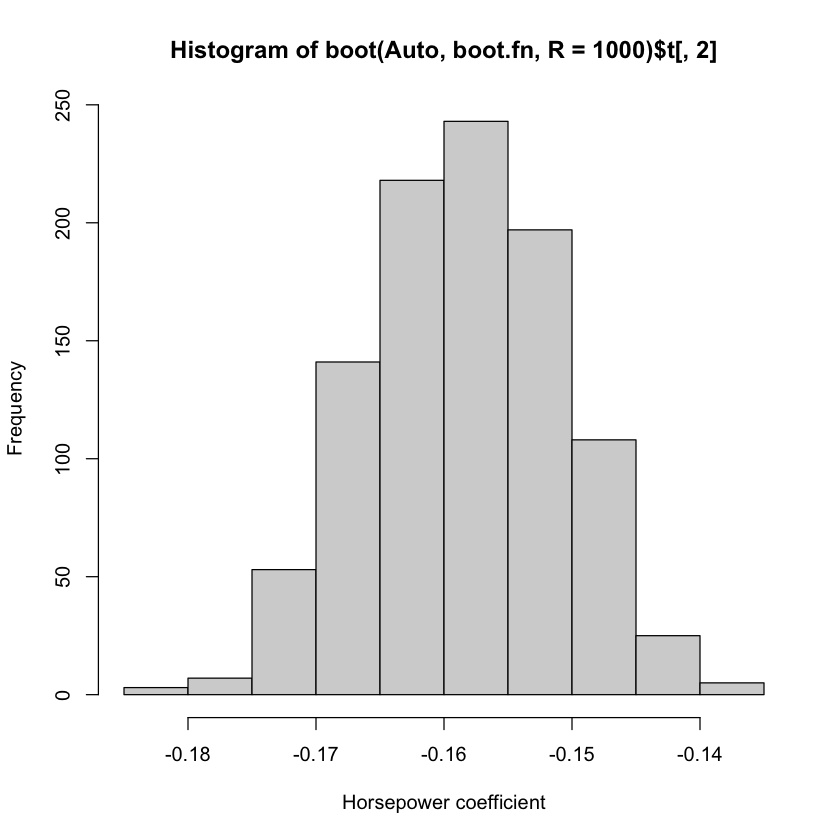

In [15]:
hist(boot(Auto, boot.fn ,R=1000)$t[,2], #indexing 2nd column
     xlab="Horsepower coefficient")

Now let's compare these results to the original model where we don't bootstrap.

In [18]:
# Parametric model
summary(lm(mpg~horsepower, data=Auto))$coef

# boot estimate
boot_obj$t0[2]

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),39.9358610,0.717498656,55.65984,1.220362e-187
horsepower,-0.1578447,0.006445501,-24.48914,7.031989e-81


horsepower 
-0.1578447

Notice that they produce qualitatively similar results in this case: the parametric estimate and the bootstrapped estimate are both about -0.1578. When the data fit the assumptions of the parametric linear regression model, the bootstrapped estimates will converge to the parametric ones.

---
# Permutation tests

Remember, that the goal of permutation tests is to use resampling *without replacement*. By doing this you define the specific null that you want to test and generate a random relationship with which to calculate $P(X|H_0)$. For this we can just use a simple *for loop*. But first, we need to define what our null is. Here let's define our null as being that there is no relationship between `horsepower` and `mpg`. In other words
$$H_0 : \hat{\beta}_{horsepower} = 0$$

If the null is that there is no relationship, then basically the question you're asking with your analysis is, "Is the relationship between horsepower and mpg stronger than it would be for randomly shuffled pairings of these variables' observations?"

*Note: You are not restricted to these 'nil' hypotheses (effect of 0, $\beta$ of 0). The advantage of these kinds of methods is that you can be as flexible as you like in defining your null.*

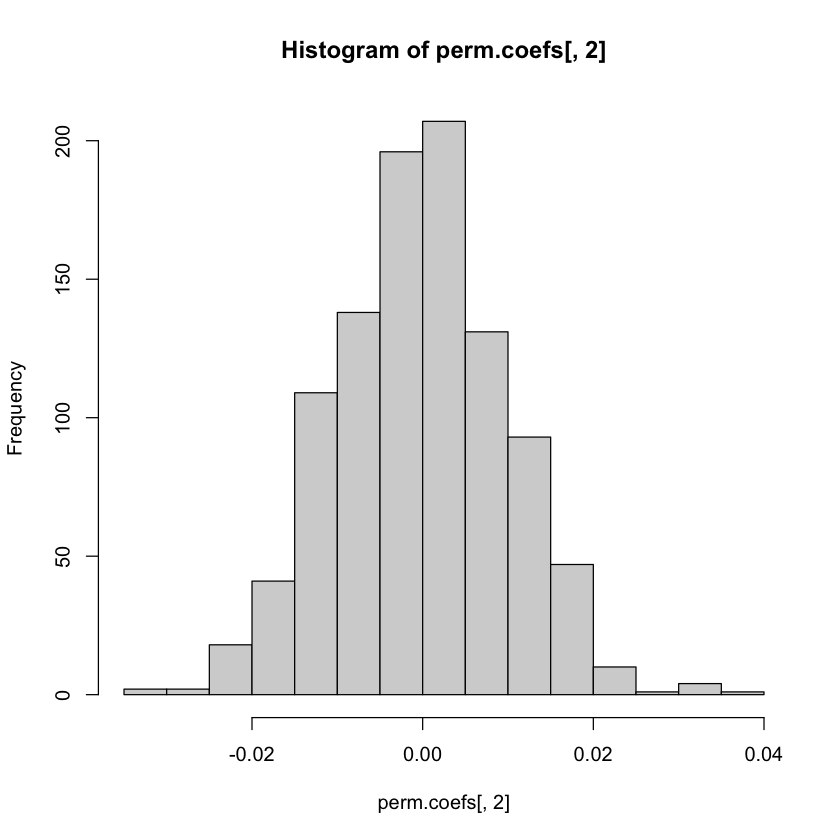

In [19]:
# First let's make a copy of the data set that we'll keep permuting
permAuto = Auto #want to preserve the non-permuted, true form of data!

# Set the number of iterations
R=1000

# Next make an output object to store the results
perm.coefs=matrix(NA,nrow=R, ncol=2) #filling with nas at first

# Now just write a for loop where we scramble the observations
# in X using the sample() function. 
for (i in 1:R){
  # This is a shuffled version of the Auto$horsepower vector:
  permAuto$horsepower=Auto$horsepower[sample(392)] 
  # then we get coeffs for linear model of shuffled horsepower to auto
  perm.coefs[i,]=coef(lm(mpg~horsepower, data=permAuto)) 
}

# Take a look at the null distributions
hist(perm.coefs[,2])


In [20]:
# Now re-estimate the real (unpermuted) effect 
perm.real = coef(lm(mpg~horsepower, data=Auto))
perm.real

(Intercept)  horsepower 
 39.9358610  -0.1578447

Notice that the real effect (-0.16) is *much* larger than the range of coefficient estimates we see for the permuted datasets - it falls outside the range of values in our empirically derived null distribution. But instead of eyeballing it, we can **empirically calculate** the probability of observing a stronger (i.e., more negative) effect (this is an empirical p-value!).

What is the probability of observing a stronger negative effect than -0.16 due to chance?

In [15]:
#sum the coefficients less than the real coefficient estimate 
#and divide by the number of repetitions to get an empirical probability 
perm.p = sum(perm.coefs[,2]<perm.real[2])/R 
perm.p

[1] 0

So we do not see any permuted models that produce results that overlap with the results from the  intact model. We can reject the null hypothesis that the $\beta$ estimate for the miles per gallon and horsepower is zero. 

*Notebook authored by Ven Popov and edited by Krista Bond, Charles Wu, Patience Stevens, Amy Sentis, and Fiona Horner.*